In [ ]:
!git clone https://github.com/raphi-web/AdvancedTopics-4.git

Cloning into 'AdvancedTopics-4'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (5/5), 5.49 MiB | 36.49 MiB/s, done.


In [ ]:
!pip install allagash[geopandas] -q
!pip install mapclassify -q

In [108]:
import geopandas as gpd
import pandas as pd
from scipy.spatial import KDTree
from shapely.geometry import LineString,Point
import matplotlib.pyplot as plt
import numpy as np
import warnings
from allagash import Coverage, Problem
import pulp
import warnings
warnings.filterwarnings("ignore")

In [109]:
#Load the Files into Dataframes
df_gem = gpd.read_file("/content/AdvancedTopics-4/Gemeindegrenzen/Gemeindegrenzen.shp")
df_krank = gpd.read_file("/content/AdvancedTopics-4/Krankenanstalten/Krankenanstalten.shp")
df_reg = pd.read_csv("/content/AdvancedTopics-4/STMK_REGION_2020.csv",sep=";",encoding="iso8859_2")

In [110]:
# Reproject to UTM
df_gem = df_gem.to_crs("EPSG:32633")
df_krank = df_krank.to_crs("EPSG:32633")

In [111]:
# Merge Districts and Population Dataframes
df_gem["GEMNR6"] = pd.to_numeric(df_gem["GEMNR6"])
df_gem = df_gem.merge(df_reg,left_on="GEMNR6",right_on="LAU_CODE")

In [112]:
# Compute Centroids
df_gem_cent = df_gem.copy()
df_gem_cent.geometry = df_gem_cent.geometry.centroid

In [113]:
# Create Supply and demand Dataframes
supply_df = df_krank.copy()
demand_df = df_gem_cent.copy()
supply_df = supply_df[["OBJECTID","geometry"]]
demand_df = demand_df[["GEMNR6","POP_TOTAL","geometry"]]
demand_df['POP_TOTAL'] = [float(x) for x in demand_df["POP_TOTAL"]]

In [114]:
print("Demand:",len(demand_df))
print("Supply:",len(supply_df))

Demand: 286
Supply: 53


In [115]:
# Use nearest Neighbour to Estimate a first Service Radius
def est_service_radi(service, demand):
      tree = KDTree([[p.x,p.y] for p in service])
      distances, idxs = tree.query([[p.x,p.y] for p in demand])
      max_dist =max(distances)
      nearest_points = [service[i] for i in idxs]
      return  max_dist,distances, nearest_points

start_radi, distances, nearest_services = est_service_radi(supply_df.geometry,demand_df.geometry)
max_dist_gem = demand_df[distances==start_radi]
print(f"Estimated Service Radius: {start_radi}")

Estimated Service Radius: 33791.11407807059


,geometry,FLAECHE_HA,GEMNR6,GEMNR,GEMNAM,GEMNAM_KUR,NUTS1,NUTS2,NUTS3,NUTS3_NAME,...,DISTRICT_NAME,LAU_CODE,LAU_NAME,TOUR_REG,REGION,STATUS,POP_TOTAL,AREA,ALTITUDE,REF_DATE
BEZNR6,,,,,,,,,,,,,,,,,,,,,
601,"POLYGON ((535025.014 5206588.115, 535012.592 5...",12746.0,60101,0101,Graz,Graz,AT2,AT22,AT221,Graz,...,Graz-Stadt,60101,Graz,Region Graz,Steirischer Zentralraum,Statutarstadt,292630,"12756,67",350,01.01.2022
603,"POLYGON ((517391.667 5165456.834, 517385.695 5...",7655.0,60351,0351,Wies,Wies,AT2,AT22,AT225,West- und Südsteiermark,...,Deutschlandsberg,60351,Wies,Süd-Weststeiermark,Südweststeiermark,Marktgemeinde,4252,"7643,82",335,01.01.2022
606,"POLYGON ((534273.949 5194660.709, 534279.938 5...",2925.0,60670,0670,Premstätten,Premstätten,AT2,AT22,AT221,Graz,...,Graz-Umgebung,60670,Premstätten,Region Graz,Steirischer Zentralraum,Marktgemeinde,6610,"2907,55",334,01.01.2022
610,"POLYGON ((536729.903 5162389.267, 536727.641 5...",4765.0,61061,1061,Straß in Steiermark,Straß,AT2,AT22,AT225,West- und Südsteiermark,...,Leibnitz,61061,Straß in Steiermark,Süd-Weststeiermark,Südweststeiermark,Marktgemeinde,6308,"3272,60",254,01.01.2022
611,"POLYGON ((495724.844 5238520.319, 495701.556 5...",14321.0,61120,1120,Trofaiach,Trofaiach,AT2,AT22,AT223,Östliche Obersteiermark,...,Leoben,61120,Trofaiach,Hochsteiermark,Obersteiermark Ost,Stadtgemeinde,10980,"14365,26",657,01.01.2022
612,"POLYGON ((402080.438 5234847.339, 401966.918 5...",7295.0,61267,1267,Stainach-Pürgg,Stainach-Pürgg,AT2,AT22,AT222,Liezen,...,Liezen,61267,Stainach-Pürgg,"Schladming-Dachstein, Tourismusmarketing GmbH",Liezen,Marktgemeinde,2766,"7309,64",664,01.01.2022
614,"POLYGON ((416973.419 5213561.167, 416969.614 5...",4227.0,61446,1446,Teufenbach-Katsch,Teufenbach-Katsch,AT2,AT22,AT226,Westliche Obersteiermark,...,Murau,61446,Teufenbach-Katsch,Urlaubsregion Murtal,Obersteiermark West,Gemeinde,1854,"4231,80",754,01.01.2022
616,"POLYGON ((509878.872 5200710.432, 509867.974 5...",1936.0,61633,1633,Söding-Sankt Johann,Söding-St. Johann,AT2,AT22,AT225,West- und Südsteiermark,...,Voitsberg,61633,Söding-Sankt Johann,Süd-Weststeiermark,Steirischer Zentralraum,Gemeinde,4163,"1936,74",343,01.01.2022
617,"POLYGON ((548095.880 5215386.869, 548095.339 5...",1747.0,61766,1766,Weiz,Weiz,AT2,AT22,AT224,Oststeiermark,...,Weiz,61766,Weiz,Thermenland Steiermark - Oststeiermark,Oststeiermark,Stadtgemeinde,11791,"1750,19",473,01.01.2022


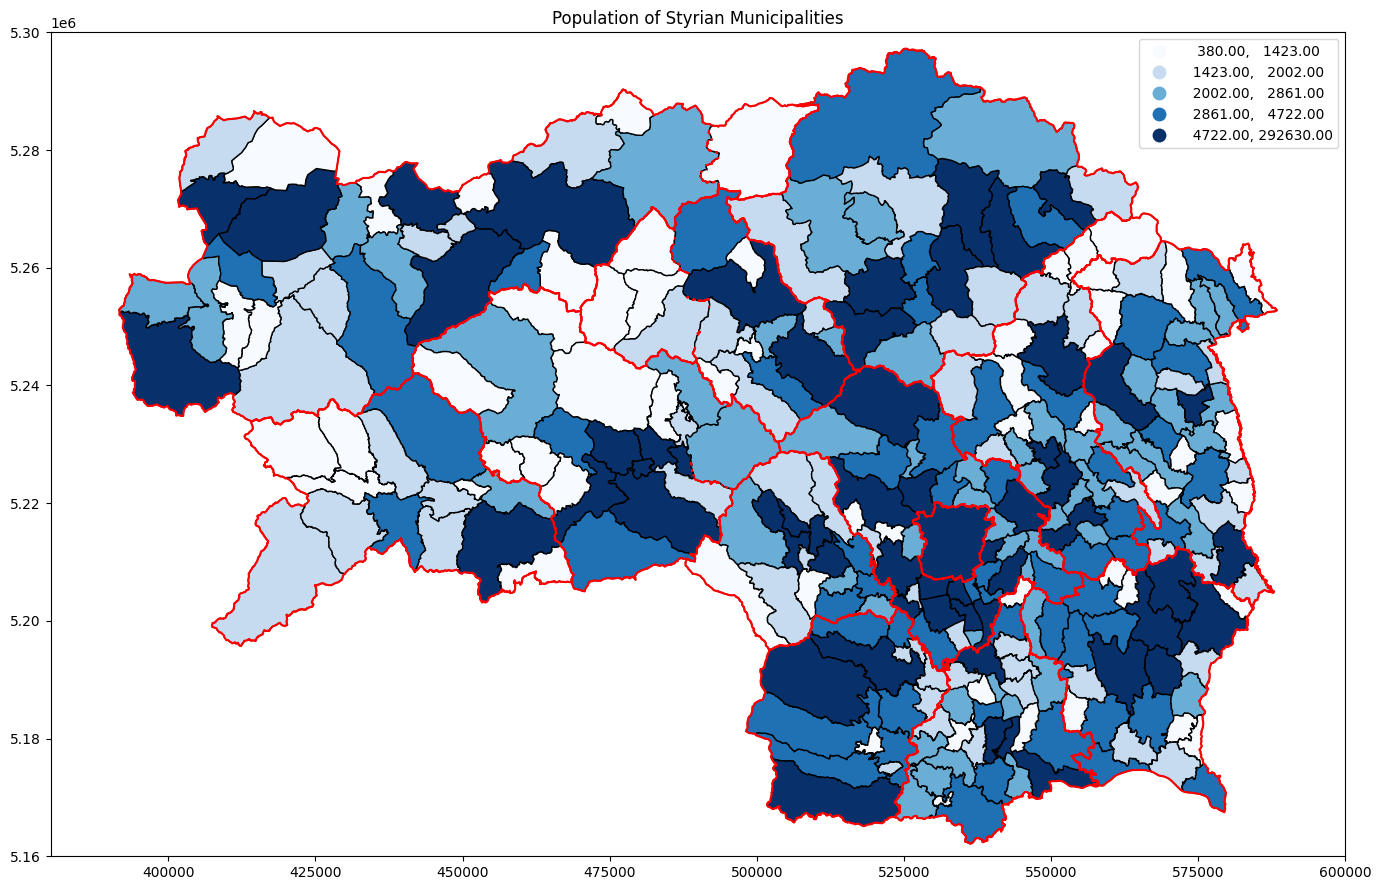

In [137]:
# Plot the Poulation
fig,ax=plt.subplots(figsize=(15,9))
df_gem.plot(column="POP_TOTAL",alpha=1,edgecolor="black", zorder = 0,scheme="quantiles",legend=True,ax=ax,cmap="Blues")
df_gem.dissolve(by="BEZNR6").boundary.plot(ax=ax, edgecolor="red",zorder=1,label="District")
ax.set_title("Population of Styrian Municipalities")
ax.set_ylim(5.16*1e6, 5.3*1e6)
ax.set_xlim(380000,600000)
plt.tight_layout()
plt.savefig("Population.png",dpi=200)
plt.show()

In [117]:
df_gem.head()

,BEZNR6,FLAECHE_HA,GEMNR6,GEMNR,GEMNAM,GEMNAM_KUR,geometry,NUTS1,NUTS2,NUTS3,...,DISTRICT_NAME,LAU_CODE,LAU_NAME,TOUR_REG,REGION,STATUS,POP_TOTAL,AREA,ALTITUDE,REF_DATE
0,623,5648.0,62390,2390,Straden,Straden,"POLYGON ((567731.699 5177683.930, 567715.461 5...",AT2,AT22,AT224,...,Südoststeiermark,62390,Straden,Thermenland Steiermark - Oststeiermark,Südoststeiermark,Marktgemeinde,3492,"5634,48",340,01.01.2022
1,623,4318.0,62389,2389,Sankt Stefan im Rosental,St. Stefan,"POLYGON ((553713.309 5201431.609, 553721.950 5...",AT2,AT22,AT224,...,Südoststeiermark,62389,Sankt Stefan im Rosental,Thermenland Steiermark - Oststeiermark,Südoststeiermark,Marktgemeinde,3832,"4302,71",319,01.01.2022
2,623,4855.0,62388,2388,Sankt Peter am Ottersbach,St. Peter,"POLYGON ((558664.224 5177762.322, 558661.211 5...",AT2,AT22,AT224,...,Südoststeiermark,62388,Sankt Peter am Ottersbach,Thermenland Steiermark - Oststeiermark,Südoststeiermark,Marktgemeinde,2909,"4834,05",271,01.01.2022
3,623,3261.0,62387,2387,Sankt Anna am Aigen,St. Anna,"POLYGON ((574261.659 5183500.227, 574258.643 5...",AT2,AT22,AT224,...,Südoststeiermark,62387,Sankt Anna am Aigen,Thermenland Steiermark - Oststeiermark,Südoststeiermark,Marktgemeinde,2357,"3265,81",411,01.01.2022
4,623,7111.0,62386,2386,Riegersburg,Riegersburg,"POLYGON ((572257.711 5212171.175, 572298.710 5...",AT2,AT22,AT224,...,Südoststeiermark,62386,Riegersburg,Thermenland Steiermark - Oststeiermark,Südoststeiermark,Marktgemeinde,4944,"7119,60",372,01.01.2022


In [118]:
# Compute service radius
log = []
step = 500 # accuracy 500 meter
radi = 0
coverd_frac = 0
while coverd_frac < 100:
  log.append((radi,coverd_frac))
  supply_buf = supply_df.copy()
  supply_buf.geometry = supply_df.geometry.buffer(radi)
  coverage = Coverage.from_geodataframes(
      demand_df,
      supply_buf,
      demand_id_col="GEMNR6",
      supply_id_col='OBJECTID',
      demand_col="POP_TOTAL")

  problem = Problem.mclp([coverage],max_supply={coverage: len(supply_buf)})
  problem.solve(pulp.PULP_CBC_CMD(msg=False))
  coverd_frac = (problem.pulp_problem.objective.value() / demand_df["POP_TOTAL"].sum()*100)
  radi += step

print(f"Service Radius: {(radi/1000):0.2f} km, covered {coverd_frac:0.2f}")

Service Radius: 34.50 km, covered 100.00


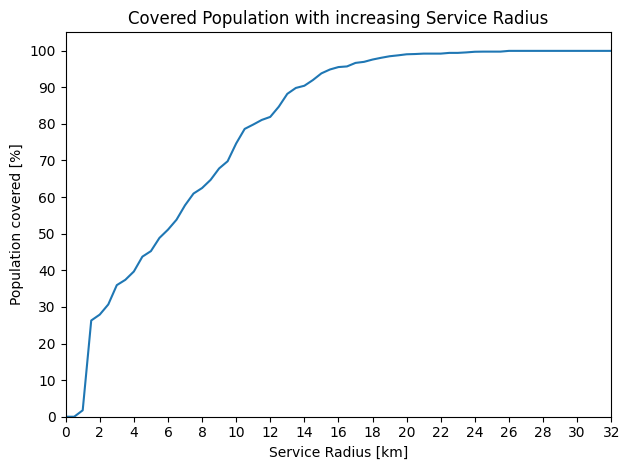

In [119]:
fig,ax=plt.subplots()
plt.plot(
    [x/1000 for x,y in log],
    [y for x,y in log]
)
plt.savefig("Covered Population with increasing Service Radius")
ax.set_xlabel("Service Radius [km]")
ax.set_ylabel("Population covered [%]")
ax.set_title("Covered Population with increasing Service Radius")


ax.set_xlim(0,(log[-1][0]/1000) % 2 + 4)
ax.set_xticks(range(0,34,2))
ax.set_ylim(0,105)
ax.set_yticks(range(0,110,10))
plt.tight_layout()
plt.savefig("CountCovered.png",dpi=200)
plt.show()

In [120]:
# get the choosen Hospitals and the district with highest distance to hospital
loc_mask = supply_df['OBJECTID'].isin(map(lambda x: int(x),problem.selected_supply(coverage)))
selected_loc_df = supply_df[loc_mask]

selected_loc_df.index = range(0,len(selected_loc_df))
max_d, distances, nearest_services = est_service_radi(selected_loc_df.geometry,demand_df.geometry)
max_dist_gem = demand_df[distances==max_d]
print(max_dist_gem)

     GEMNR6  POP_TOTAL                        geometry
186   61205      809.0  POINT (477992.080 5285982.394)


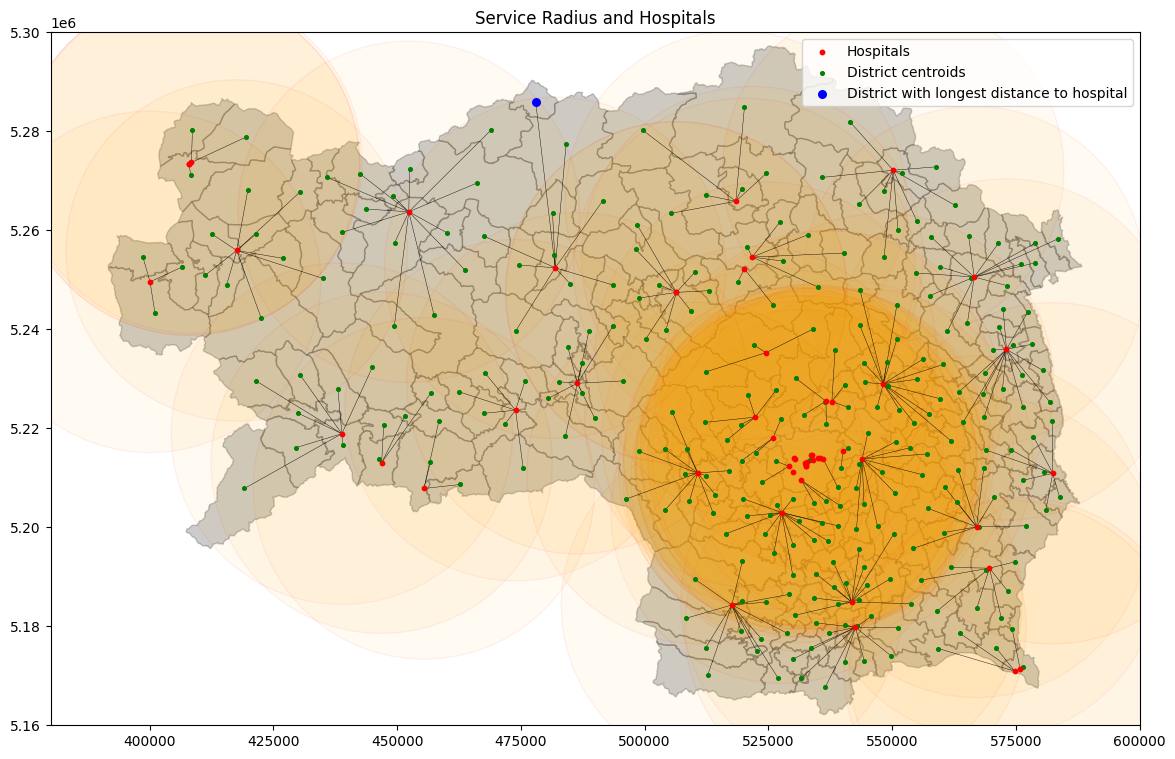

In [121]:
# Visualize  service radius with  Hospitals
fig,ax=plt.subplots(figsize=(16,9))
df_gem.plot(ax=ax,color="black",alpha=0.2,edgecolor="black", zorder = 0)

for s,d in zip(nearest_services, demand_df.geometry):
  plt.plot([s.x,d.x],[s.y,d.y],color="black",linewidth=0.3,zorder=2)

selected_loc_df.geometry.buffer(radi).plot(ax=ax,color="orange",alpha=0.05,edgecolor="red",zorder=1,label="Service Radius")
selected_loc_df.plot(ax=ax,color="red",markersize=10,zorder=4, label="Hospitals")
demand_df.plot(ax=ax, color="green", markersize=7,zorder=3, label="District centroids")
max_dist_gem.plot(ax=ax,color='blue',markersize=30,zorder=5, label="District with longest distance to hospital")
plt.legend()
ax.set_ylim(5.16*1e6, 5.3*1e6)
ax.set_xlim(380000,600000)
ax.set_title("Service Radius and Hospitals")
plt.savefig("SrHospitals.png",dpi=200)
plt.show()

In [122]:
# add new hospital to supply_df
supply_df_new_host = supply_df.copy()
supply_df_new_host.loc[len(supply_df_new_host)] = [len(supply_df_new_host)+1, max_dist_gem.geometry.to_list()[0]]

In [123]:
# Compute new service radius

step = 500 # accuracy 500 meter
radi = 0
coverd_frac = 0
while coverd_frac < 100:
  supply_buf = supply_df_new_host.copy()
  supply_buf.geometry = supply_df_new_host.geometry.buffer(radi)

  coverage = Coverage.from_geodataframes(
      demand_df,
      supply_buf,
      demand_id_col="GEMNR6",
      supply_id_col='OBJECTID',
      demand_col="POP_TOTAL")

  problem = Problem.mclp([coverage],max_supply={coverage: len(supply_buf)})
  problem.solve(pulp.PULP_CBC_CMD(msg=False))
  coverd_frac = (problem.pulp_problem.objective.value() / demand_df["POP_TOTAL"].sum()*100)
  radi += step

print(f"Service Radius: {(radi/1000):2f} km, covered {coverd_frac:2f}")


Service Radius: 24.000000 km, covered 100.000000


In [124]:
loc_mask = supply_df_new_host['OBJECTID'].isin(map(lambda x: int(x),problem.selected_supply(coverage)))
selected_loc_df = supply_df_new_host[loc_mask]
selected_loc_df.index = range(0,len(selected_loc_df))
max_d, distances, nearest_services = est_service_radi(selected_loc_df.geometry,demand_df.geometry)
max_dist_gem = demand_df[distances==max_d]

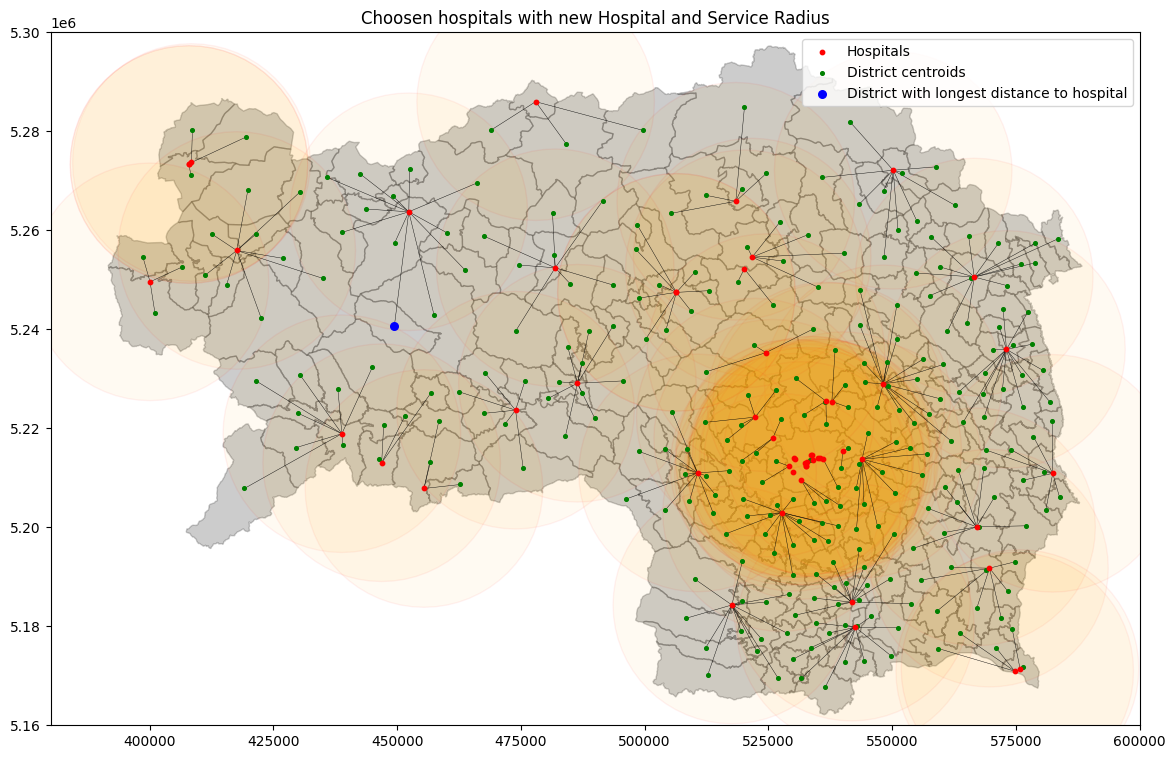

In [125]:
# plot hospitals with new hospital location and service radius
fig,ax=plt.subplots(figsize=(16,9))
df_gem.plot(ax=ax,color="black",alpha=0.2,edgecolor="black", zorder = 0)

for s,d in zip(nearest_services, demand_df.geometry):
  plt.plot([s.x,d.x],[s.y,d.y],color="black",linewidth=0.3,zorder=2)

selected_loc_df.geometry.buffer(radi).plot(ax=ax,color="orange",alpha=0.05,edgecolor="red",zorder=1,label="Service Radius")
selected_loc_df.plot(ax=ax,color="red",markersize=10,zorder=4, label="Hospitals")
demand_df.plot(ax=ax, color="green", markersize=7,zorder=3, label="District centroids")
max_dist_gem.plot(ax=ax,color='blue',markersize=30,zorder=5, label="District with longest distance to hospital")
plt.legend()
ax.set_ylim(5.16*1e6, 5.3*1e6)
ax.set_xlim(380000,600000)
ax.set_title("Choosen hospitals with new Hospital and Service Radius")
plt.savefig("HospitalNew.png",dpi=200)
plt.show()